In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

In [161]:
# load data
mnist_train = pd.read_csv('train.csv')
mnist_test = pd.read_csv('test.csv')

In [162]:
# calculate the ratio of test data
len(mnist_test)/(len(mnist_test) + len(mnist_train))

0.4

In [163]:
# split the train data according to the ratio 0.4
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4)

In [180]:
# generate validation set
for train_index, validate_index in split.split(mnist_train, mnist_train['label']):
    train_data = mnist_train.loc[train_index]
    validate_data = mnist_train.loc[validate_index]

In [181]:
train_label = train_data['label']
train_data.drop('label', axis=1, inplace = True)
train_label.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)

In [182]:
validate_label = validate_data['label']
validate_data.drop('label', axis=1, inplace = True)
validate_label.reset_index(drop=True, inplace=True)
validate_data.reset_index(drop=True, inplace=True)

In [183]:
all_train = np.concatenate([train_data, validate_data])
all_label = np.concatenate([train_label, validate_label])

In [173]:
pic = np.array(train_data.loc[3555]).reshape(28,28)

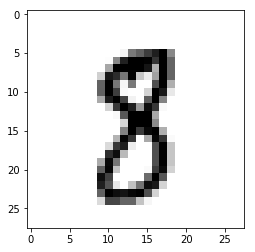

In [174]:
plt.imshow(pic,cmap = matplotlib.cm.binary)

In [135]:
# this function is for tweaking the parameters
# use a loop to try different parameters
def NN_model_on_train_set(n_neurons_1=300, n_neurons_2 = 100, learning_rate = 0.01, n_epochs = 30, batch_size = 50):
    # here we build a two layers NN model and test on validation set, you may improve it to a CV version
    # n_neurons_1 : number of neurons in the first layer
    # n_neurons_2  : number of neurons in the second layer
    # learning_rate : the learning rate of BGD
    # n_epochs : times of training the model
    # batch_size : since we adopted BGD, then we need to define the size of a size
    # initialize variables
    X = tf.placeholder(tf.float32, shape=(None, 28*28), name='X')
    y = tf.placeholder(tf.int64, shape=(None), name = 'y')

    # weights
    W1 = tf.Variable(tf.truncated_normal((28*28, n_neurons_1),stddev = 0.01), name = 'layer_1')
    W2 = tf.Variable(tf.truncated_normal((n_neurons_1, n_neurons_2),stddev = 0.01), name = 'layer_2')
    W3 = tf.Variable(tf.truncated_normal((n_neurons_2 , 10),stddev = 0.01), name = 'output_layer')

    # biases
    b1 = tf.Variable(tf.zeros([n_neurons_1]), name='b_1')
    b2 = tf.Variable(tf.zeros([n_neurons_2]), name='b_2')
    b3 = tf.Variable(tf.zeros([10]), name='b_3')

    # the output of each layer
    Z1 = tf.nn.relu(tf.matmul(X,W1) + b1)
    Z2 = tf.nn.relu(tf.matmul(Z1, W2) + b2)
    output = tf.matmul(Z2, W3) + b3

    # define loss function. Cross-entropy was adopted rather than MSE
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = output)
    loss = tf.reduce_mean(xentropy, name='loss')

    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

    # define accuracy
    correct = tf.nn.in_top_k(output, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    # run everything
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            for iteration in range(len(train_data) // batch_size):
                # 因为要batchSize=50个50个的取，取到末尾时可能不够，所以用个if判定一下
                if (iteration + 1) * batch_size <= len(train_data):
                    X_batch = np.array(train_data[iteration * batch_size : iteration * batch_size + batch_size])
                    y_batch = np.array(train_label[iteration * batch_size : iteration * batch_size + batch_size])
                else:
                    X_batch = np.array(train_data[iteration * batch_size : ])
                    y_batch = np.array(train_label[iteration * batch_size : ])
                sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
            # train error
            acc_train = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
            # test error
            acc_test = accuracy.eval(feed_dict={X:np.array(validate_data),
                                               y:np.array(validate_label)})
            print(epoch, 'Train accuracy:', acc_train, 'Test accuracy:', acc_test)

In [175]:
# this function is for making the prediction
def NN_model_to_predict(n_neurons_1=300, n_neurons_2 = 100, learning_rate = 0.01, n_epochs = 30, batch_size = 50):
    # here we build a two layers NN model and test on validation set, you may improve it to a CV version
    # n_neurons_1 : number of neurons in the first layer
    # n_neurons_2  : number of neurons in the second layer
    # learning_rate : the learning rate of BGD
    # n_epochs : times of training the model
    # batch_size : since we adopted BGD, then we need to define the size of a size
    # initialize variables
    X = tf.placeholder(tf.float32, shape=(None, 28*28), name='X')
    y = tf.placeholder(tf.int64, shape=(None), name = 'y')

    # weights
    W1 = tf.Variable(tf.truncated_normal((28*28, n_neurons_1),stddev = 0.01), name = 'layer_1')
    W2 = tf.Variable(tf.truncated_normal((n_neurons_1, n_neurons_2),stddev = 0.01), name = 'layer_2')
    W3 = tf.Variable(tf.truncated_normal((n_neurons_2 , 10),stddev = 0.01), name = 'output_layer')

    # biases
    b1 = tf.Variable(tf.zeros([n_neurons_1]), name='b_1')
    b2 = tf.Variable(tf.zeros([n_neurons_2]), name='b_2')
    b3 = tf.Variable(tf.zeros([10]), name='b_3')

    # the output of each layer
    Z1 = tf.nn.relu(tf.matmul(X,W1) + b1)
    Z2 = tf.nn.relu(tf.matmul(Z1, W2) + b2)
    output = tf.matmul(Z2, W3) + b3

    # define loss function. Cross-entropy was adopted rather than MSE
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = output)
    loss = tf.reduce_mean(xentropy, name='loss')

    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

    # define accuracy
    correct = tf.nn.in_top_k(output, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            for iteration in range(len(train_data) // batch_size):
                if (iteration + 1) * batch_size <= len(train_data):
                    X_batch = np.array(all_train[iteration * batch_size : iteration * batch_size + batch_size])
                    y_batch = np.array(all_label[iteration * batch_size : iteration * batch_size + batch_size])
                else:
                    X_batch = np.array(all_train[iteration * batch_size : ])
                    y_batch = np.array(all_label[iteration * batch_size : ])
                sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
            acc_train = accuracy.eval(feed_dict={X:X_batch, y:y_batch})


        predict_output = sess.run(output,feed_dict={X:np.array(mnist_test)})
        return np.argmax(predict_output, axis= 1)

In [176]:
prediction = NN_model_to_predict(n_neurons_1=300, n_neurons_2 = 100, learning_rate = 0.01, n_epochs = 50, batch_size = 50)

In [178]:
df = pd.DataFrame({'ImageId': [i for i in range(1,len(prediction)+1)],
                  'Label': prediction})

In [179]:
df.to_csv('./my_prediction.csv', index=None)